# **Прогнозирование оттока клиентов**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# **Описание данных**
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


# **План работы**
 - 1. Загрузим данные, проведем первичный анализ данных, взглянем на пропуски/дубликаты/типы данных, объединим датасеты.
 - 2. Проведем предобработку данных - обработаем пропуски, преобразуем признаки с помощью OHE, попытаемся создать какие-либо новые признаки (например, продолжительность договора до ухода клиента) и выделим целевой признак.
 - 3. Подробнее рассмотрим признаки - построим графики распределения, корреляционную матрицу, сделаем некоторые промежуточные выводы. Также попытаемся решить проблему с дисбалансом классов (если таковая будет присутствовать).
 - 4. Обучим модели и проверим их на тестовой выборке. Для оценки качества будем использовать ROC-AUC и Accuracy.

# 1. Загрузка данных и первичный анализ

In [37]:
import warnings; warnings.filterwarnings("ignore", category=Warning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import re
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

In [2]:
try:
    path = '/content/'
    df_contract = pd.read_csv(path + 'contract.csv')
    df_internet = pd.read_csv(path + 'internet.csv')
    df_personal = pd.read_csv(path + 'personal.csv')
    df_phone = pd.read_csv(path + 'phone.csv')
except:
    path = '/datasets/final_provider/'
    df_contract = pd.read_csv(path + 'contract.csv')
    df_internet = pd.read_csv(path + 'internet.csv')
    df_personal = pd.read_csv(path + 'personal.csv')
    df_phone = pd.read_csv(path + 'phone.csv')

In [3]:
df_list = [[df_contract, 'Информация о договорах'], [df_personal, 'Персональные данные клиентов'], 
           [df_internet, 'Информациях об интернет-услугах'], [df_phone, 'Информация об услугах телефонии']]

Данные загружены, теперь взглянем на каждый датасет по отдельности:

In [4]:
for df in df_list:
    print('\033[1m' + df[1] + '\033[0m')
    display(df[0].head(3))
    display(df[0].info(memory_usage=False))
    print('')
    print('Количество дубликатов -', df[0].duplicated().sum())
    print('Количество пустых значений -', df[0].isnull().sum().sum())
    print('/'*50)
    print('')

Информация о договорах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)

None


Количество дубликатов - 0
Количество пустых значений - 0
//////////////////////////////////////////////////

Персональные данные клиентов


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)

None


Количество дубликатов - 0
Количество пустых значений - 0
//////////////////////////////////////////////////

Информациях об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)

None


Количество дубликатов - 0
Количество пустых значений - 0
//////////////////////////////////////////////////

Информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)

None


Количество дубликатов - 0
Количество пустых значений - 0
//////////////////////////////////////////////////



Наблюдаем что по отдельности в каждом датасете отсутствуют пропуски и дубликаты. Однако различное количество строк дает нам понять что не все клиенты пользуются дополнительными интернет-услугами и телефонии. Теперь объединим датасет и еще раз взглянем на него.

In [5]:
df = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))
df = df.join(df_personal.set_index('customerID'))
df = df.join(df_internet.set_index('customerID'))
df = df.rename_axis('customerID').reset_index()
df = df.rename({'gender': 'Gender', 'customerID': 'CustomerID'}, axis='columns')

print('\033[1m' + 'Объединенный датасет'+ '\033[0m')
display(df.head(5))
display(df.info(memory_usage=False))
print('')
print('Количество дубликатов по столбцу CustomerID -', df['CustomerID'].duplicated().sum())
print('Количество пустых значений -', df.isnull().sum().sum())

Объединенный датасет


,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
CustomerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
MultipleLines       6361 non-null object
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: float64(1), int64(1), object(18)

None


Количество дубликатов по столбцу CustomerID - 0
Количество пустых значений - 11364


Датасет успешно объединен, теперь переходим к обработке данных и подробному рассмотрению признаков.

# 2. Предобработка данных и исследовательский анализ.

## 2.1. Обработка пропусков

После объединения датасета, однако как и предполагалось - не все клиенты пользуются дополнительными услугами, соответственно вместо пропусков можем сразу же проставить этим клиентам значение 'No'.

In [6]:
empty_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[empty_cols] = df[empty_cols].fillna('No')

Пропуски обработаны, теперь переведем тип данных в некоторых столбцах к необходимому, создадим новый столбец со значениями продолжительности договора, приведем столбец TotalCharges к числовому типу и извлечем целевой признак создав новый столбец ClientOut.

In [7]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'],format = '%Y-%m-%d')
df['FixedEndDate'] = pd.to_datetime(df['EndDate'][df['EndDate'] != 'No'], format = '%Y-%m-%dT%H:%M:%S')

df['ClientOut'] = np.where((df['FixedEndDate'].isnull() != True ), 1, 0)

df['FixedEndDate'][df['FixedEndDate'].isnull() == True] = pd.Timestamp('2020-02-01')

df['Duration'] = df['FixedEndDate'] - df['BeginDate']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.replace(r'^\s+', ''))
df['TotalCharges'] = df['TotalCharges'].fillna(0)

display(df['ClientOut'].value_counts())
display(df['FixedEndDate'].isnull().value_counts())

0    5174
1    1869
Name: ClientOut, dtype: int64

False    7043
Name: FixedEndDate, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
CustomerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
MultipleLines       7043 non-null object
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
FixedEndDate        7043 non-null datetime64[ns]
ClientOut      

In [9]:
df.head(3)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,Gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FixedEndDate,ClientOut,Duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,DSL,No,Yes,No,No,No,No,2020-02-01,0,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No,Male,...,DSL,Yes,No,Yes,No,No,No,2020-02-01,0,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,Male,...,DSL,Yes,Yes,No,No,No,No,2019-12-01,1,61 days


Данные обработаны, теперь переходим к рассмотрению распределения признаков в датасете.

# 2.2. Исследовательский анализ данных

В первую очередь создаим функцию которая будет выводить график распределения того или иного признака.

In [10]:
def plotting(x, xlabel_name, nbins=0, purpose='Boolean'):
    if purpose == 'Boolean':
        labels, counts = np.unique(x, return_counts=True)
        plt.figure(figsize=(x.nunique()*2, 2), dpi = 100)
        plt.bar(labels, 
                counts, 
                align='center', 
                color='green', 
                alpha=0.7, 
                edgecolor='black')
        for i in range(len(labels)):
            plt.text(i, counts[i]//2, counts[i], ha = 'center')
    elif purpose == 'Numeric':
        plt.figure(figsize=(10, 2), dpi = 100)
        plt.hist(x=x, 
                 color='green', 
                 alpha=0.7, 
                 edgecolor='black',
                 bins=nbins)
    plt.grid(axis='y')
    plt.ylabel('Кол-во клиентов')
    plt.xlabel(xlabel_name);
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.show()

Функция подготовлена, начнем рассмотрение с социальных признаков клиентов.

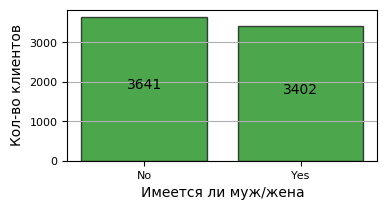

In [11]:
plotting(df['Partner'], 'Имеется ли муж/жена')

По признаку семейного положения клиенты разделились примерно половну - 51.5% клиентов не имеют мужа/жены, 48% клиентов замужем или женаты.

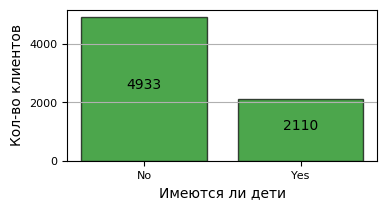

In [12]:
plotting(df['Dependents'], 'Имеются ли дети')

Примерно у 30% клиентов имеются дети, у оставшихся 70% клиентов дети отсутствуют.

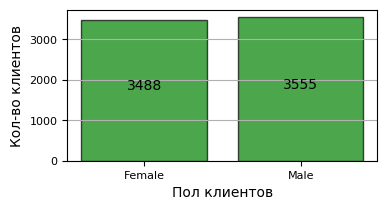

In [13]:
plotting(df['Gender'], 'Пол клиентов')

По гендерному признаку клиенты распределены поровну, переходим дальше

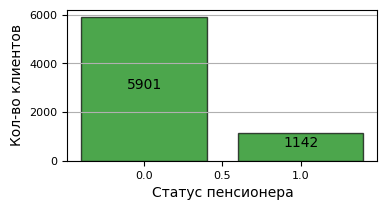

In [14]:
plotting(df['SeniorCitizen'], 'Статус пенсионера')

Примерно 16% клиентов имеют статус пенсионера или находятся в пожилом возрасте

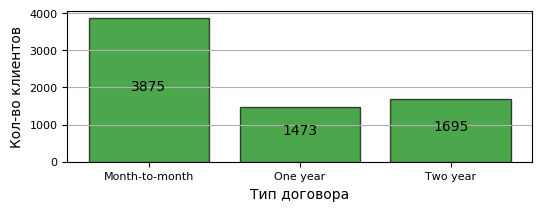

In [15]:
plotting(df['Type'], 'Тип договора')

Видим что наибольшей популярностью пользуется месячный тип договора, однако годовой и двухгодовой тип договора в целом тоже пользуются достаточным успехом у клиентов.

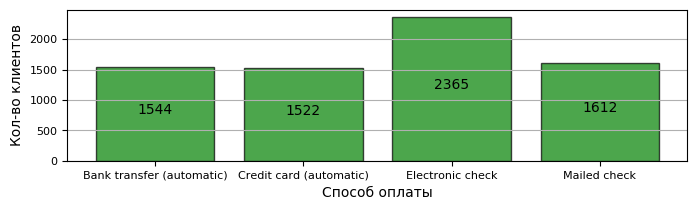

In [16]:
plotting(df['PaymentMethod'], 'Способ оплаты')

Наиболее популярным способом оплаты у клиентов является судя по всему ручная электронная оплата, оставшиеся способы оплаты занимают между собой приблизительно равные места

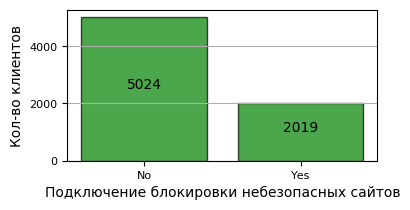

In [17]:
plotting(df['OnlineSecurity'], 'Подключение блокировки небезопасных сайтов')

Примерно 30% клиентов используют услугу блокировки небезопасных сайтов, что является вполне неплохим результатом

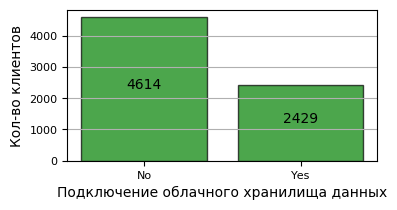

In [18]:
plotting(df['OnlineBackup'], 'Подключение облачного хранилища данных')

Около 35% клиентов пользуются услугой облачного хранилища данных, услуга более популярна чем блокировка небезопасных сайтов

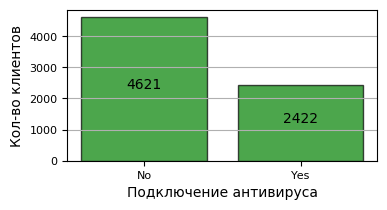

In [19]:
plotting(df['DeviceProtection'], 'Подключение антивируса')

Подключением антивируса воспользовались примерно 35% пользователей, тоже достаточно хороший показатель

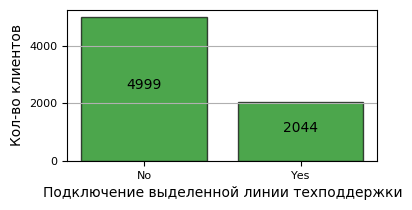

In [20]:
plotting(df['TechSupport'], 'Подключение выделенной линии техподдержки')

По популярности подключение выделенной линии техподдержки на данный момент находится примерно на одном уровне с блокировкой небезопасных сайтов - 28-29% клиентов пользуется данной услугой

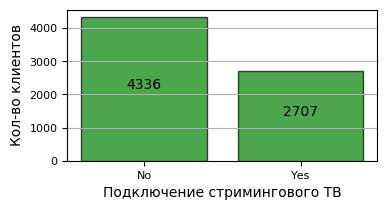

In [21]:
plotting(df['StreamingTV'], 'Подключение стримингового ТВ')

Стриминговым телевидением пользуется около 40% клиентов, что сразу же выводит её в ряд наиболее популярных и полезных услуг

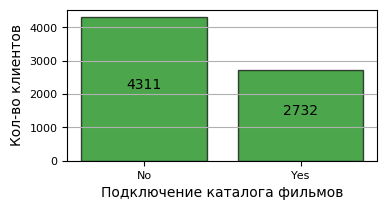

In [22]:
plotting(df['StreamingMovies'], 'Подключение каталога фильмов')

Судя по всему подключением каталога фильмов пользуются одновременно с подключением стримингового телевидения, поэтому эта услуга является также наиболее популярной у клиентов.

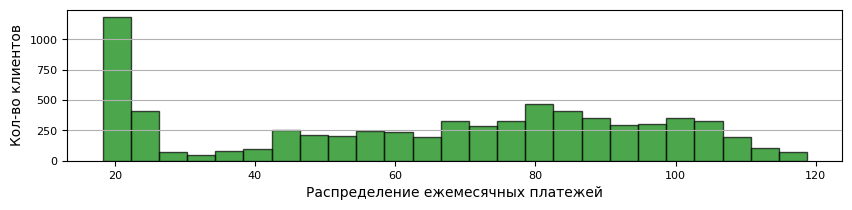

In [23]:
plotting(df['MonthlyCharges'], 'Распределение ежемесячных платежей', 25, 'Numeric')

Наибольшая часть клиентов в месяц платит минимальную сумму - возможно это клиенты у которых не подключена ни одна дополнительная услуга. 

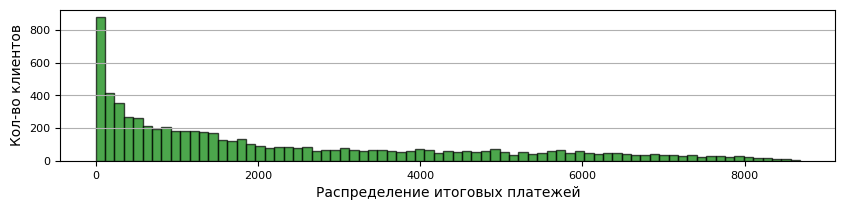

In [24]:
plotting(df['TotalCharges'], 'Распределение итоговых платежей', 75, 'Numeric')

По распределению итоговых платежей можно сказать что оно распределено нормально, большая доля небольших сумм итоговых платежей судя по всему связана с оттоком старых клиентов и появлением новых.

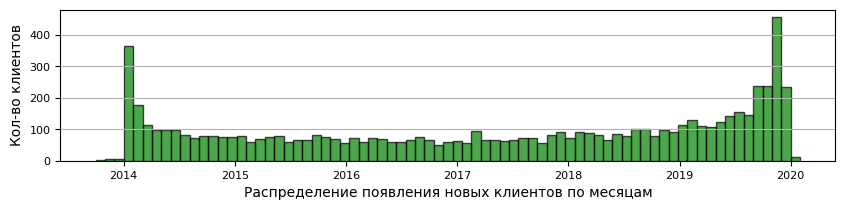

In [25]:
plotting(df['BeginDate'], 'Распределение появления новых клиентов по месяцам', 75, 'Numeric')

Наблюдаем что наибольший прирост клиентов наблюдался в начале 2014 года (возможно связано с началом сбора подобных данных в компании), после этого в период с 2015 по 2018 гг. количество новых клиентов составляло примерно 50-100 человек в месяц. В 2019 и 2020 году эти цифры начинают расти и доходят до 200 человек в месяц.

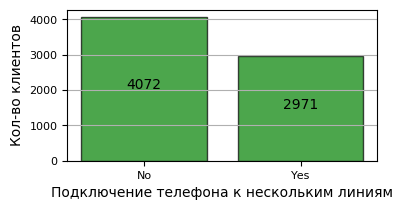

In [26]:
plotting(df['MultipleLines'], 'Подключение телефона к нескольким линиям')

Около 40% процентов клиентов используют дополнительные линии при подключении телефона, если эти клиенты используют данную услугу в коммерческих целях - в таком случае это достаточно хороший показатель.

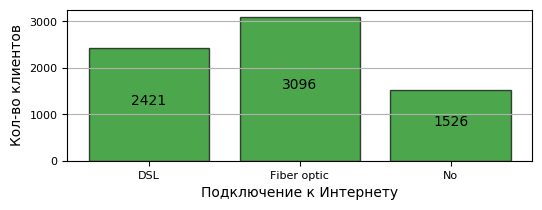

In [27]:
plotting(df['InternetService'], 'Подключение к Интернету')

Около 20% пользователей не подключены к интернету у данного провайдера, большинство клиентов подключены к интернету с помощью оптоволоконного кабеля, 35% клиентов подключены к интернету с помощью телефонной линии.

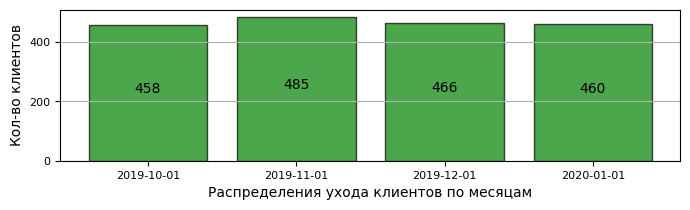

In [28]:
plotting(df.loc[(df['ClientOut'] == 1), 'FixedEndDate'].dt.strftime('%Y-%m-%d'), 'Распределения ухода клиентов по месяцам')

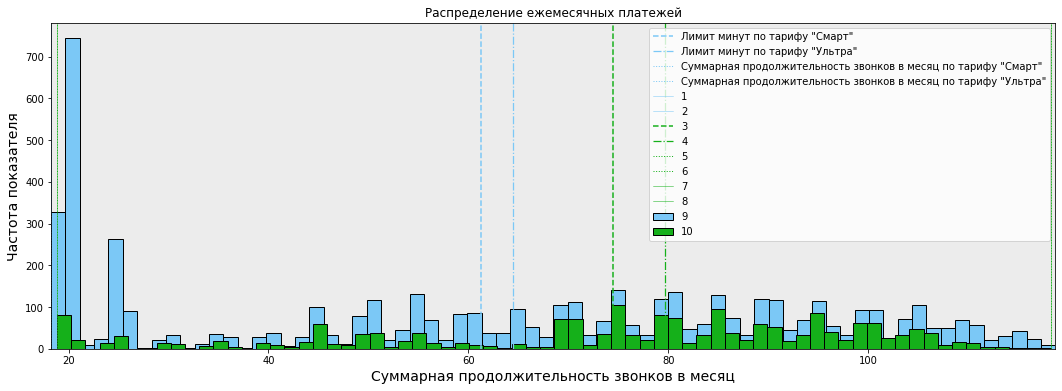

In [29]:
monthlycharges_list = [df.query('ClientOut == 0')['MonthlyCharges'], 
                       df.query('ClientOut == 1')['MonthlyCharges']]
colorlist = ['#7BC8F6', '#15B01A']
quantile_list=[0.25, 0.75]

ax = plt.gca()
xlim = [df['MonthlyCharges'].min(), df['MonthlyCharges'].max()]
title = 'Распределение ежемесячных платежей'

for i in range(len(monthlycharges_list)):
    monthlycharges_list[i].plot(kind='hist', bins=70, figsize=(18, 6), ec='black', ax=ax, 
                                color=colorlist[i], title=title, xlim=xlim)
    plt.axvline(x=monthlycharges_list[i].mean(), linewidth=1.5, linestyle='--', color=colorlist[i])
    plt.axvline(x=monthlycharges_list[i].median(), linewidth=1.25, linestyle='dashdot', color=colorlist[i])
    plt.axvline(x=monthlycharges_list[i].max(), linewidth=1, linestyle='dotted', color=colorlist[i])
    plt.axvline(x=monthlycharges_list[i].min(), linewidth=1, linestyle='dotted', color=colorlist[i])
    for j in range(len(quantile_list)):
        plt.axvline(x=monthlycharges_list[i].quantile(j, interpolation='nearest'), linewidth=0.5, color=colorlist[i])

ax.set_facecolor('0.925')
plt.xlabel('Суммарная продолжительность звонков в месяц', fontsize=14)
plt.ylabel('Частота показателя', fontsize=14)
plt.legend(['Лимит минут по тарифу "Смарт"', 'Лимит минут по тарифу "Ультра"', 
            'Суммарная продолжительность звонков в месяц по тарифу "Смарт"', 
            'Суммарная продолжительность звонков в месяц по тарифу "Ультра"', 
           '1',
           '2',
           '3',
           '4',
           '5',
           '6',
           '7',
           '8',
           '9',
           '10'], 
           prop={'size':10})
plt.show()

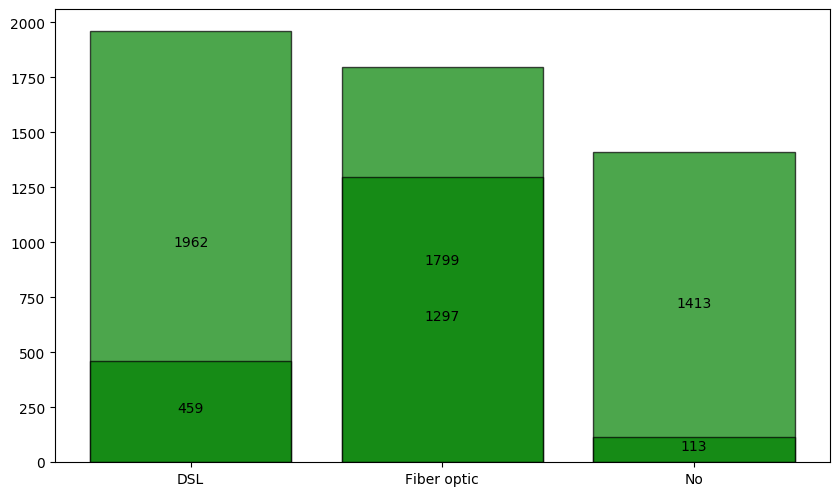

In [30]:
labels, counts = np.unique(df.query('ClientOut == 0')['InternetService'], return_counts=True)
plt.figure(figsize=(10, 6), dpi = 100)
plt.bar(labels, 
        counts, 
        align='center', 
        color='green', 
        alpha=0.7, 
        edgecolor='black')
for i in range(len(labels)):
    plt.text(i, counts[i]//2, counts[i], ha = 'center')
labels, counts = np.unique(df.query('ClientOut == 1')['InternetService'], return_counts=True)
#plt.figure(figsize=(df.query('ClientOut == 1')['InternetService'].nunique()*2, 2), dpi = 100)
plt.bar(labels, 
        counts, 
        align='center', 
        color='green', 
        alpha=0.7, 
        edgecolor='black')
for i in range(len(labels)):
    plt.text(i, counts[i]//2, counts[i], ha = 'center')

На основании собранных данных можно сделать вывод о том что за период с октября 2019 года по январь 2020 года количество ушедших клиентов в среднем составляет 450-500 человек в месяц.

## 2.2.1. Промежуточные выводы:

Рассмотрев основные признаки из объединеннего датасета, мы можем сделать **следующие выводы:**

- **В среднем около 30-35% клиентов пользуются дополнительными услугами** - блокировка небезопасных сайтов, облачное хранилище данных, подключение антивируса, выделенная линия техподдержки, стриминговое ТВ и каталог фильмов.
- **Подключение телефона к нескольким линиям** в 2019-2020 у данного провайдера **пользуется наибольшей популярностью**, данной услугой воспользовались 42% клиентов.
- Большинство клиентов в качестве способа оплаты **предпочитают банковские переводы, оплаты кредитной или дебетовой картой**.
- **Тип договора у 55% клиентов ежемесячный**, оставшаяся доля клиентов заключает договор либо на один год, либо на два.
- **Около 16% клиентов являются пенсионерами** либо пожилыми людьми.
- **У 30% клиентов имеются дети**.
- **С 2019 года наблюдается повышенный прирост новых клиентов** (100-200 чел. в месяц), который на протяжении периода с 2015 по 2018 года оставался на примерно одном и том же уровне (50-100 чел. в месяц).
- **Большая часть клиентов платит минимальную сумму по договору**, возможно что это клиенты не использующие никаких дополнительных услуг.

Теперь можем переходить к обучению и проверкам моделей.

# 3. Обучение и проверка моделей.

## 3.1 Преобразование признаков

В первую очередь преобразуем столбцы со значениями Yes/No в числовые 0/1.

In [31]:
yes_no_columns = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 
                  'OnlineBackup', 'OnlineSecurity', 'Dependents', 'Partner', 'PaperlessBilling', 'MultipleLines']
df[yes_no_columns] = df[yes_no_columns].replace(to_replace=['No', 'Yes'], value=[0, 1])
df['StreamingMovies'].value_counts()

0    4311
1    2732
Name: StreamingMovies, dtype: int64

Столбцы преобразованы успешно, теперь создадим новый признак, который будет означать что пользователь является новым клиентом. За интервал возьмем ноябрь 2019 года по февраль 2020 года.

In [32]:
df['NewClient'] = np.where((df['BeginDate'] > '2019-10-30') & (df['BeginDate'] < '2020-02-02') != True, 1, 0)
df['NewClient'].value_counts()

1    6342
0     701
Name: NewClient, dtype: int64

Столбец успешно создан, теперь избавимся от лишних столбцов с датой и ID пользователей, преобразуем тип данных столбца Duration в числовой, и переведем оставшиеся столбцы с текстовыми значениями к числовым значениям с помощью OHE.

In [33]:
df = df.drop(['BeginDate', 'EndDate', 'FixedEndDate', 'CustomerID'], axis=1)

df['Duration'] = df['Duration'].dt.days
df = pd.get_dummies(df, columns = ['Gender', 'Type', 'PaymentMethod', 'InternetService'], drop_first = True)
display(df.head(3))

,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Duration,NewClient,Gender_Male,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,1,29.85,29.85,0,0,1,0,0,1,0,...,31,0,0,0,0,0,1,0,0,0
1,0,56.95,1889.50,0,0,0,0,1,0,1,...,1036,1,1,1,0,0,0,1,0,0
2,1,53.85,108.15,0,0,0,0,1,1,0,...,61,1,1,0,0,0,0,1,0,0


Указанные выше шаги выполнены успешно, теперь построим корреляционную матрицу для уточнения взаимосвязей между признаками и целевым признаком.

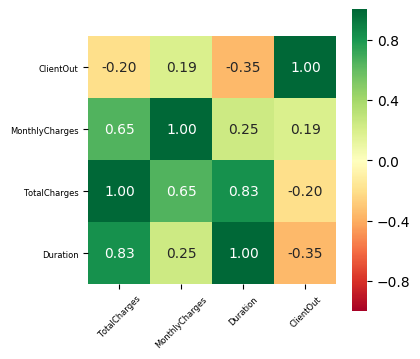

In [34]:
corr_clientout  = df[['TotalCharges', 'MonthlyCharges', 'Duration', 'ClientOut']].corr()
corr_clientout = corr_clientout.sort_values(by='ClientOut', ascending=False)
plt.figure(figsize=(4,4), dpi= 100)

sns.heatmap(corr_clientout, cmap='RdYlGn', center=0, 
            annot=True, fmt='.2f', vmin=-1, vmax=1, square = True)

plt.xticks(fontsize=6, rotation=45)
plt.yticks(fontsize=6)
plt.show()

Наблюдаем высокую взаимосвязь между TotalCharges и оставшимися количественными признаками, поэтому лучше всего будет избавиться от этого столбца.

In [35]:
df = df.drop(['TotalCharges'], axis=1)

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://stepik.org/lesson/90035/step/3?unit=66281

Между категориальными и числовыми признаками корреляцию считать не нужно.
Поскольку признаки имеют разную природу считать корреляцию Пирсона/Спирмена не имеет смысла.
Для расчета корреляции используем следующую меру:
Признаки будут коррелированны положительно, если E(X1|X2=1) > E(X1|X2=-1), отрицательно наоборот; За меру корреляции возьмем разность мат.ожиданий E(X1|X2=1) - E(X1|X2=-1)

функция, которая будем считать эту меру

In [47]:
# создадим функцию, которая считает корреляциооную меру E(X1|X2=1) - E(X1|X2=-1)

data_corr=df.copy() # создадим копию исходного датасета без столбцов в которых только пропуски
scaler = StandardScaler() # нормализация данных 

def corr_calculation (column):
    matrix = pd.concat((data_corr[column], pd.Series(np.ravel(label))), axis=1) # создает таблицу со столбцом признака и метки
    # ravel - для перевод данных в массив 
    matrix = matrix.dropna() # удаляет пустые значение в этой таблице
    
    #Данные имеют разный масштаб и их нужно сравнивать между собой, произведем нормализацию при помощи Slacer
    # scaler - вычитает среднее и делит на стандартное отклонение
    matrix[column] = scaler.fit_transform(matrix[column].values.reshape(-1, 1)) # reshape - длятрансформации массива в кортеж 
    
    # Расчет E(X1|X2=1)
    E_X_churn = matrix[matrix[0] == 1][column].mean() # мат. ожидания для по объектам, где target = 1 (был отток)
    
    # Расчет E(X1|X2=0)
    E_X_notchurn = matrix[matrix[0] == 0][column].mean() # мат. ожидания для по объектам, где target = 0 ( не было оттока)
    
    #корреляционный коэффициент
    сorr = E_X_churn - E_X_notchurn
    #знак корреляции не важен, найдем только коррелирующие переменные
    return np.abs(E_X_churn - E_X_notchurn)

In [50]:
num_cols = df.dtypes[df.dtypes != 'object'].index
num_cols = num_cols.drop(['ClientOut', 'Duration'])
label = df['ClientOut']
#Посчитаем корреляции между признаками
#хранить будем в переменной
correlation_list = []

#по всем колонкам с целочисленными значениями вычисляем корреляции и записываем в лист : [0.0739153726574856, 'Var56']
for column in num_cols:
    correlation_list.append([corr_calculation(column), column])
    
#pandas объект для хранения корреляций
df_corr = pd.DataFrame(correlation_list, columns=['correlation', 'variable']).sort_values(
    by='correlation',  ascending=False)  
df_corr.head(10)

,correlation,variable
19,0.697619,InternetService_Fiber optic
15,0.684559,Type_Two year
17,0.683801,PaymentMethod_Electronic check
20,0.516138,InternetService_No
1,0.437924,MonthlyCharges
0,0.434456,PaperlessBilling
14,0.402736,Type_One year
6,0.387802,OnlineSecurity
9,0.372961,TechSupport
5,0.371937,Dependents


Наблюдаем что все три рассмотренных признака имеют взаимосвязь с целевым признаком, наиболее значимым из которых является продолжительность договора.

Теперь разобъем датасет на тренировочную и тестовую выборку, выделим признаки и целевой признак.

## 3.2. Разбиение признаков

In [34]:
random_state = 12345

train, test = train_test_split(df, test_size = 0.25, random_state=random_state)

df_list = [train, test]
df_names = ['Обучающая выборка', 'Тестовая выборка']
for i in range(len(df_list)):
    print('\033[1m' + df_names[i] + '\033[0m')
    print('Размер:', df_list[i].shape)
    print('Доля от исходного датасета:', round(len(df_list[i]) / len(df) * 100, 2), '%')
    print('')

Обучающая выборка
Размер: (5282, 23)
Доля от исходного датасета: 75.0 %

Тестовая выборка
Размер: (1761, 23)
Доля от исходного датасета: 25.0 %



Обучающая и тестовая выборка сформированы, теперь выделим в них целевой признак и сформируем признаки.

In [35]:
features_train = train.drop(['ClientOut'], axis=1)
target_train = train['ClientOut']
   
features_test = test.drop(['ClientOut'], axis=1)
target_test = test['ClientOut']

Признаки сформированы, теперь переходим к обучению и тестированию моделей.

# 3.3. Тестирование моделей.

Для этого напишем функцию, которая на входе будет принимать наименование модели и набор гиперпараметров, а внутри с помощью GridSearchCV определит наиболее оптимальный набор гиперпараметров, обучит и проверит модель на Accuracy Score/Precision/Recall/F1 и рассчитает ROC-AUC метрику.

В качестве моделей будут использованы:
- **Логистическая регрессия**
- **Случайный лес**
- **CatBoost**
- **XGBoost**
- **LGBM**

In [36]:
fpr_list = []
tpr_list = []
model_name_list = []
def model_testing(model_name, parametrs):
    
    rocauc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    
    model = model_name()

    grid = GridSearchCV(model, parametrs, cv=5, scoring=rocauc)
    grid.fit(features_train, target_train)
    
    test_model = model_name(**grid.best_params_, random_state=random_state)
    test_model.fit(features_train, target_train)

    model_train_predictions = test_model.predict(features_train)
    model_test_predictions = test_model.predict(features_test)

    train_accuracy_score = accuracy_score(target_train, model_train_predictions)
    valid_accuracy_score = accuracy_score(target_test, model_test_predictions)
    precision = precision_score(target_test, model_test_predictions)
    recall = recall_score(target_test, model_test_predictions)
    f1 = f1_score(target_test, model_test_predictions)
    
    probabilities = test_model.predict_proba(features_test)
    probabilities_one = probabilities[:,1]
    auc_roc = roc_auc_score(target_test, probabilities_one)
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    model_name_list.append(type(test_model).__name__)
    
    if type(test_model).__name__ == 'RandomForestClassifier' \
    or type(test_model).__name__ == 'LGBMClassifier':
        plt.figure(figsize=(7, 7), dpi=100)
        plt.barh(features_train.columns, test_model.feature_importances_,
                 color='green',
                 alpha=0.7,
                 edgecolor='black')
        plt.show()
    elif type(test_model).__name__ == 'CatBoostClassifier':
        feature_import = test_model.get_feature_importance(Pool(features_train, target_train), prettified = True)
        plt.figure(figsize=(7, 7), dpi=100)
        plt.barh(feature_import['Feature Id'],feature_import['Importances'],
                 color='green',
                 alpha=0.7,
                 edgecolor='black')
        plt.show()
    print('Результаты модели "'+ '\033[1m' + type(test_model).__name__ + '\033[0m' +'":')
    print('AUC-ROC - ', round(auc_roc, 3))
    print('F1-мера -', round(f1, 3))
    print('Точность -', round(precision, 3))
    print('Полнота -', round(recall, 3))
    print('Accuracy Score на обучающей выборке - ', round(train_accuracy_score, 3))
    print('Accuracy Score на валидационной выборке - ', round(valid_accuracy_score, 3))
    print('Параметры модели:')
    print(grid.best_params_)

Функция подготовлена, начнем тестирование с модели линейной регресии. 
### 3.3.1. Логистическая регрессия

In [37]:
%%time
parametrs = {'solver': ['liblinear'],
             'intercept_scaling': [4.0, 4.5, 5.0, 5.5, 6.0],
             'class_weight': ['balanced'],
             'C': [1.5, 1.75, 2]}
model_testing(LogisticRegression, parametrs)

Результаты модели "LogisticRegression":
AUC-ROC -  0.842
F1-мера - 0.63
Точность - 0.518
Полнота - 0.804
Accuracy Score на обучающей выборке -  0.754
Accuracy Score на валидационной выборке -  0.746
Параметры модели:
{'C': 2, 'class_weight': 'balanced', 'intercept_scaling': 6.0, 'solver': 'liblinear'}
CPU times: user 8.49 s, sys: 6.42 s, total: 14.9 s
Wall time: 14.9 s


Для максимально простой модели - логистическая регрессия показала достаточно хорошие результаты - 0.837 по метрике ROC-AUC, однако значения Accuracy Score хромают, переходим к модели случайного леса.

### 3.3.2. Случайный лес

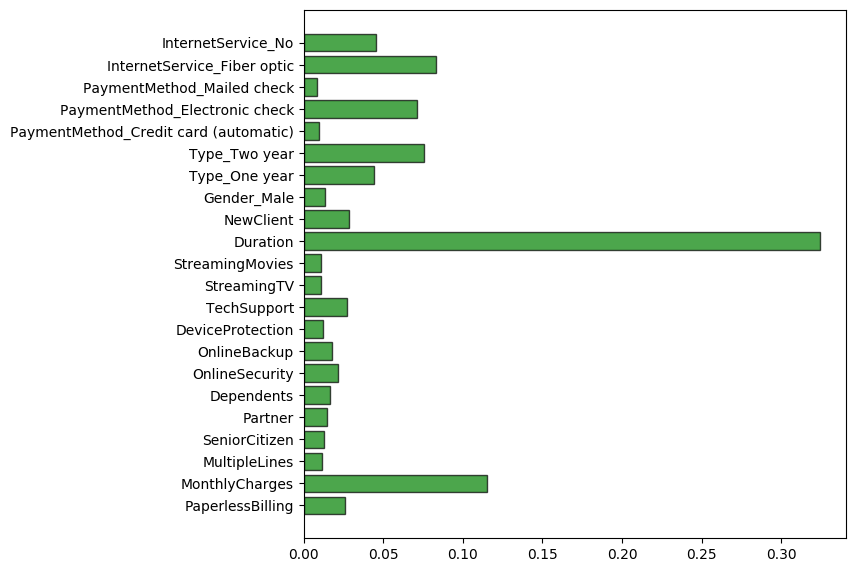

Результаты модели "RandomForestClassifier":
AUC-ROC -  0.868
F1-мера - 0.616
Точность - 0.729
Полнота - 0.534
Accuracy Score на обучающей выборке -  0.866
Accuracy Score на валидационной выборке -  0.821
Параметры модели:
{'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 7, 'n_estimators': 40}
CPU times: user 1min 18s, sys: 478 ms, total: 1min 19s
Wall time: 1min 19s


In [38]:
%%time
parametrs = {'max_depth': range (20, 30, 5),
             'min_samples_leaf': range (5, 8),
             'min_samples_split': range (5, 8),
             'n_estimators': range (30, 50, 5)}
model_testing(RandomForestClassifier, parametrs)

Случайный лес как по метрике ROC-AUC так и по Accuracy Score работает слегка лучше чем логистическая регрессия, однако временные затраты у данной модели куда больше чем у логистической регрессии. Переходим к CatBoost Classifier

### 3.3.3. CatBoost Classifier

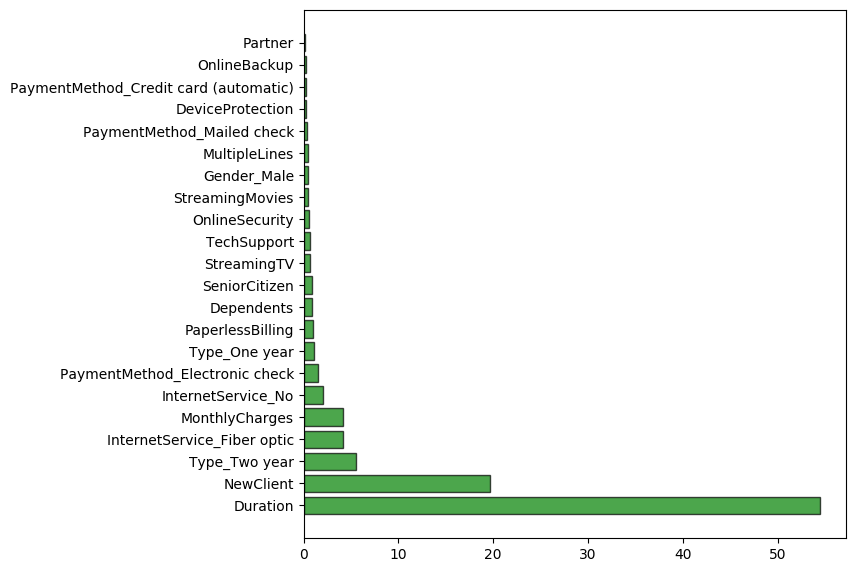

Результаты модели "CatBoostClassifier":
AUC-ROC -  0.918
F1-мера - 0.73
Точность - 0.847
Полнота - 0.641
Accuracy Score на обучающей выборке -  0.898
Accuracy Score на валидационной выборке -  0.872
Параметры модели:
{'eval_metric': 'AUC', 'iterations': 200, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'max_depth': 4}
CPU times: user 1min 12s, sys: 11.9 s, total: 1min 24s
Wall time: 1min 50s


In [39]:
%%time
parametrs = {'max_depth' : [4], 
             'loss_function' : ['Logloss'], 
             'eval_metric' : ['AUC'], 
             'logging_level' : ['Silent'], 
             'iterations' : [175, 200, 225]}
model_testing(CatBoostClassifier, parametrs)

На данный момент CatBoost показывает наилучшие результаты по метрике ROC-AUC - 0.902, однако Accuracy Score и временные затраты меньше чем у случайного леса, переходим к XGBoost 

### 3.3.4. XGBoost Classifier

In [40]:
%%time
parametrs = {'n_estimators': range(40, 80, 10), 
             'max_depth': range(20, 50, 5), 
             'silent' : [True],
             'scale_pos_weight': [1]}
model_testing(xgb.XGBClassifier, parametrs)

Результаты модели "XGBClassifier":
AUC-ROC -  0.888
F1-мера - 0.674
Точность - 0.763
Полнота - 0.603
Accuracy Score на обучающей выборке -  0.994
Accuracy Score на валидационной выборке -  0.843
Параметры модели:
{'max_depth': 20, 'n_estimators': 70, 'scale_pos_weight': 1, 'silent': True}
CPU times: user 3min 19s, sys: 685 ms, total: 3min 20s
Wall time: 3min 21s


На валидационной выборке XGBoost показывает наилучшие результаты по Accuracy Score, ROC-AUC метрика слегка меньше чем у CatBoost, однако временные затраты оказались в несколько раз больше того же CatBoostа. Переходим к последней модели - LGBM Classifier.

### 3.3.5. LGBM Classifier

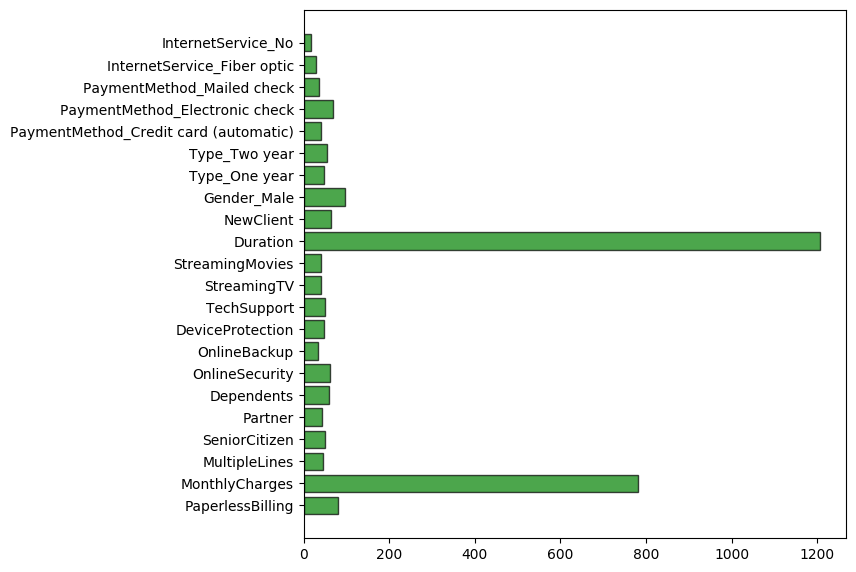

Результаты модели "LGBMClassifier":
AUC-ROC -  0.905
F1-мера - 0.711
Точность - 0.805
Полнота - 0.637
Accuracy Score на обучающей выборке -  0.92
Accuracy Score на валидационной выборке -  0.861
Параметры модели:
{'learning_rate': 0.1, 'max_depth': 9}
CPU times: user 15.1 s, sys: 508 ms, total: 15.7 s
Wall time: 15.7 s


In [41]:
%%time
parametrs = {'max_depth': range(1, 10, 2),
            'learning_rate' : [0.01, 0.05, 0.1]}
model_testing(LGBMClassifier, parametrs)

LGBM показал достаточно крепкие результаты наравне с CatBoost и LGBM, лучший Accuracy Score на валидационной выборке, и второе место по ROC-AUC метрике.

Теперь когда все модели прошли тестирование, построим график ROC-кривой и выведем окончательные выводы.

<Figure size 432x288 with 0 Axes>

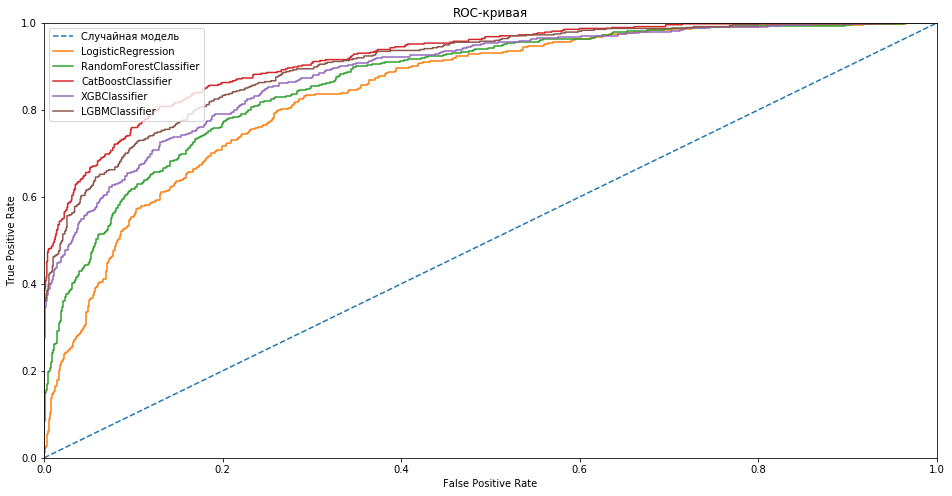

In [42]:
plt.figure()
plt.figure(figsize=(16,8))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=model_name_list[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc= 'upper left') 
plt.show()

По результатам тестирования **наилучшие показатели по метрикам ROC-AUC и Accuracy Score показала модель LGBM Classifier** - 0.905 и 0.861 на тестовой выборке. По соотношению метрик и временных затрат лучший результат также дает модель LGBM Classifier. Результаты оставшихся моделей следующие:

- **Логистическая регрессия:**
    - ROC-AUC - 0.842
    - Accuracy Score - 0.754
    - Затрачиваемое время - 4 секунды
- **Случайный лес:**
    - ROC-AUC - 0.866
    - Accuracy Score - 0.823
    - Затрачиваемое время - 1 минута
- **CatBoost Classifier:**
    - ROC-AUC - 0.918
    - Accuracy Score - 0.872
    - Затрачиваемое время - 10 секунд
- **XGBoost Classifier:**
    - ROC-AUC - 0.888
    - Accuracy Score - 0.843
    - Затрачиваемое время - 2 минуты и 30 секунд.

# 4. Итоговый вывод

По результатам проведенного анализа датасета и работы моделей мы можем сделать следующие выводы:

- **В среднем около 30-35% клиентов пользуются дополнительными услугами**
- **Тип договора у 55% клиентов ежемесячный**, оставшаяся доля клиентов заключает договор либо на один год, либо на два.
- **С 2019 года наблюдается повышенный прирост новых клиентов**
- **Большая часть клиентов платит минимальную сумму по договору**
- **Наибольшую корреляцию с целевым признаком имеют следующие показатели**:
    - Тип договора
    - Продолжительность договора с момента заключения
    - Размер выплат по договору
    - Подключение к интернету
    - Дополнительные услуги (за исключением стримингового ТВ, каталога фильмов и подключения антивируса)
- **В качестве основной рабочей модели предлагается модель LGBM Classifier** с результатами по метрикам ROC-AUC и Accuracy Score - 0.897 и 0.854, соответственно. По временным затратам эта модель также является наиболее оптимальной.